In [1]:
# Install these packages if you haven't already!

# pip install pandas
# pip install scikit-learn
# pip install joblib
# pip install numpy
# pip install xgboost
# pip install matplotlib
# pip install seaborn

# __author__    = "Siem Vonk"
# __studentID__ = "i6290798"

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import joblib

import os
print(os.getcwd())
os.makedirs("files", exist_ok=True)

c:\Users\vonks\OneDrive\Documents\! Code\Course 5 ML\MSc_ML_Assignment


## Training of the models

In [71]:
data_original = pd.read_csv("data_regression_train_df.csv")
data = data_original.dropna(subset=['Viability']) # 0 missing rows for viability

# Missing values for each variable
missing_values = data.isnull().sum()
print(missing_values)

# Select variables with less than 3000 missing values (around 1/3rd of the samples)
columns_to_keep = missing_values[missing_values < 3000].index
data = data[columns_to_keep]

# Export columns to keep for new data (not included in training so they have to be removed)
columns_to_keep.to_series().to_csv("files/columns_to_keep.txt", index=False, header=False)

NP_type                  0
Coating               6133
core_size_nm           644
hydro_size_nm         6804
Surf_charge_mV        4779
Surface_area_m2_g     8380
shape                 5511
Dose_microg_mL         165
Duration_h             277
Cell_name                0
Cell_species             0
cell_Organ               0
Cell_morphology         17
Cell_age               596
cell_type               77
sex                   2429
Assay                    0
Test_indicator         195
nanomaterial_group       0
Viability                0
dtype: int64


In [72]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = data.drop(columns=['Viability'])
y = data['Viability']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [73]:
# Export test set for testing new data pipeline (should return same results)
test_df = X_test.copy()
test_df['Viability'] = y_test
test_df.to_csv("test_set.csv", index=False) # You can import this at the top to test

In [74]:
# Impute X_train and use the same fitted imputer for X_test
from assignment_functions import assignment_impute
imputer = assignment_impute(max_iter=10)

X_train= imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Save the imputer for new data
joblib.dump(imputer, 'files/imputer.pkl')

['files/imputer.pkl']

In [75]:
# Encode categorical variables
from sklearn.preprocessing import OneHotEncoder

# Encode based on training data only
categorical_cols = X_train.select_dtypes(include='object').columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Ignore any unknown categories in new data

X_train_encoded = pd.DataFrame(
    encoder.fit_transform(X_train[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_train.index
)

X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_test.index
)

# Find indices of numeric columns in X_train (same as X_test)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# Merge encoded categorical features and the numeric features
X_train_final = pd.concat([X_train[numeric_cols], X_train_encoded], axis=1) # axis = 1 horizontal
X_test_final = pd.concat([X_test[numeric_cols], X_test_encoded], axis=1)

# Save the encoder and feature order
joblib.dump(encoder, 'files/encoder.pkl')
joblib.dump(X_train_final.columns.tolist(), 'files/feature_order.pkl')


['files/feature_order.pkl']

In [76]:
# Scaling X_train and X_test 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Mean=0, std=1
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)
joblib.dump(scaler, 'files/scaler.pkl') # Save the scaler for new data

# Convert back to dataframes with column names and index preserved
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_final.columns, index=X_train_final.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_final.columns, index=X_test_final.index)



In [77]:
# Lasso (took around 3 seconds)
from sklearn.linear_model import LassoCV

param_grid_lasso = {
    'alpha': [0.01, 0.1, 0.5, 1, 10, 100, 1000]
}

# Lasso regression with cross-validation kfold 5
lasso_cv = LassoCV(alphas=param_grid_lasso['alpha'], cv=5, random_state=1, max_iter=5000)
lasso_cv.fit(X_train_scaled_df, y_train)

y_pred_lasso = lasso_cv.predict(X_test_scaled_df)

lasso_best = lasso_cv.alpha_
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression Results")
print(f"Mean Squared Error (MSE): {mse_lasso:.4f}")
print(f"R² Score: {r2_lasso:.4f}")
print(f"Best Lasso alpha: {lasso_best}")

Betas_Lasso = pd.Series(lasso_cv.coef_, index=X_train_scaled_df.columns)
Betas_Lasso = Betas_Lasso.abs().sort_values(ascending=False)
print(f"\nLasso Coefficients")
print(Betas_Lasso.head(5))

# Save the model
joblib.dump(lasso_cv, 'files/lasso.pkl')

Lasso Regression Results
Mean Squared Error (MSE): 783.3916
R² Score: 0.2565
Best Lasso alpha: 0.1

Lasso Coefficients
NP_type_Ag           4.978563
NP_type_CdTe         4.227897
Assay_MTS            4.093269
NP_type_MWCNT        3.978024
NP_type_Dendrimer    3.783435
dtype: float64


['files/lasso.pkl']

In [78]:
# Ridge (took around 3 seconds)
from sklearn.linear_model import RidgeCV

param_grid_ridge = {
    'alpha': [0.01, 0.1, 0.5, 1, 10, 100, 1000]
}

# Ridge regression with 5-fold CV
ridge_cv = RidgeCV(alphas=param_grid_ridge['alpha'], cv=5)
ridge_cv.fit(X_train_scaled_df, y_train)

y_pred_ridge = ridge_cv.predict(X_test_scaled_df)

ridge_best = ridge_cv.alpha_
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Results")
print(f"Mean Squared Error (MSE): {mse_ridge:.4f}")
print(f"R² Score: {r2_ridge:.4f}")
print(f"Best Ridge alpha: {ridge_best}")

Betas_Ridge = pd.Series(ridge_cv.coef_, index=X_train_scaled_df.columns)
Betas_Ridge = Betas_Ridge.abs().sort_values(ascending=False)
print(f"\nRidge Coefficients")
print(Betas_Ridge.head(5))


# Around the same as lasso so not saved


Ridge Regression Results
Mean Squared Error (MSE): 784.2102
R² Score: 0.2557
Best Ridge alpha: 1000.0

Ridge Coefficients
NP_type_Ag            3.704867
NP_type_Dendrimer     3.528715
NP_type_EudragitRL    3.359812
NP_type_CdTe          3.008252
Assay_MTS             2.792514
dtype: float64


In [79]:
# Elastic Net (took around 2 minutes)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

EN = ElasticNet(random_state=1, max_iter=5000)
param_grid_EN = {
    'alpha': [0.01, 0.1, 0.5, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.6, 0.9, 1.0]  # Lasso (l1_ratio=1) to Ridge (=0)
}

# EN regression with cross-validation kfold 5
EN_cv = GridSearchCV(EN, param_grid_EN, cv=5, scoring='neg_mean_squared_error')
EN_cv.fit(X_train_scaled_df, y_train)

y_pred_EN = EN_cv.predict(X_test_scaled_df)

In [80]:
# EN results

mse_EN = mean_squared_error(y_test, y_pred_EN)
r2_EN = r2_score(y_test, y_pred_EN)

best_params_EN = EN_cv.best_params_
best_alpha_EN = best_params_EN['alpha']
best_l1_ratio_EN = best_params_EN['l1_ratio']

print(f"Mean Squared Error (MSE): {mse_EN:.4f}")
print(f"R² Score = {r2_EN:.4f}")
print(f"Best alpha: {best_alpha_EN} and l1_ratio: {best_l1_ratio_EN}")

# Get the best ElasticNet model from GridSearchCV
best_en_model = EN_cv.best_estimator_

Betas_EN = pd.Series(best_en_model.coef_, index=X_train_scaled_df.columns)
print(f"\nElastic Net Coefficients")
print(Betas_EN.head(5))

# Lasso seems to perform better and is a lot faster so EN is not saved


Mean Squared Error (MSE): 783.4415
R² Score = 0.2564
Best alpha: 0.1 and l1_ratio: 0.9

Elastic Net Coefficients
core_size_nm      0.680199
Dose_microg_mL   -2.820204
Duration_h       -3.118705
NP_type_Ag       -4.757026
NP_type_Al2O3     0.489946
dtype: float64


In [81]:
# Random Forest default (took around 3 seconds)

from sklearn.ensemble import RandomForestRegressor

# Using default (MSE) criterion for regression
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=123,
    n_jobs=-1
)

rf.fit(X_train_scaled_df, y_train)
y_pred_rf_old = rf.predict(X_test_scaled_df)
joblib.dump(rf, 'files/random_forest_default.pkl')

mse_rf_old = mean_squared_error(y_test, y_pred_rf_old)
r2_rf_old = r2_score(y_test, y_pred_rf_old)

print(f"Random Forest Regression Results")
print(f"Mean Squared Error (MSE): {mse_rf_old:.4f}")
print(f"R^2 Score: {r2_rf_old:.4f}")


Random Forest Regression Results
Mean Squared Error (MSE): 471.5396
R^2 Score: 0.5525


In [82]:
# Random Forest parameter optimization (took around 30 seconds)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Parameter grid (keep n_estimators fixed)
param_grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Base model
rf_base = RandomForestRegressor(
    n_estimators=100,
    random_state=123,
    n_jobs=-1
)

# Grid search
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Fit to scaled training data
grid_search.fit(X_train_scaled_df, y_train)

# Get the best model
best_rf = grid_search.best_estimator_

# Predict and evaluate
y_pred_rf = best_rf.predict(X_test_scaled_df)
joblib.dump(best_rf, 'files/random_forest.pkl')

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regression Results (Optimized)")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"R^2 Score: {r2_rf:.4f}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits

Random Forest Regression Results (Optimized)
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 5}
Mean Squared Error (MSE): 442.7312
R^2 Score: 0.5798


In [83]:
# xgboost 
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1)
xgb_model.fit(X_train_scaled_df, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled_df)
joblib.dump(xgb_model, 'files/xgb.pkl')

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regression Results:")
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"R² Score: {r2_xgb:.4f}")

# Worse than random forest but better than lasso and EN (R2 of 0.33)


XGBoost Regression Results:
Mean Squared Error (MSE): 702.6405
R² Score: 0.3331


In [84]:
from sklearn.svm import SVR

# SVR model (RBF kernel is default)
svr = SVR(C=1.0, epsilon=0.1)
svr.fit(X_train_scaled_df, y_train)

y_pred_svr = svr.predict(X_test_scaled_df)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("\nSVR Regression Results:")
print(f"Mean Squared Error (MSE): {mse_svr:.4f}")
print(f"R² Score: {r2_svr:.4f}")

# very low R2 score (0.08) so not saved



SVR Regression Results:
Mean Squared Error (MSE): 972.2903
R² Score: 0.0772


In [85]:
# KNN regression (almost instant)

from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled_df, y_train)

y_pred_knn = knn.predict(X_test_scaled_df)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("KNN Regression Results")
print(f"Mean Squared Error (MSE): {mse_knn:.4f}")
print(f"R² Score: {r2_knn:.4f}")

# Decent R2 score (0.39)
joblib.dump(knn, 'files/knn.pkl')


KNN Regression Results
Mean Squared Error (MSE): 640.5922
R² Score: 0.3920


['files/knn.pkl']

In [86]:
# Neural Network (MLP) regression (took around 1 minute)
from sklearn.neural_network import MLPRegressor

# Multi-layer Perceptron regressor with one hidden layer of 100 neurons, ReLU activation
mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=123)
mlp.fit(X_train_scaled_df, y_train)

# Predict
y_pred_mlp = mlp.predict(X_test_scaled_df)

In [87]:
# Neural Networks Evaluation
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("Neural Network Regression Results")
print(f"Mean Squared Error (MSE): {mse_mlp:.4f}")
print(f"R² Score: {r2_mlp:.4f}")

# Decent R2 score (0.39)
joblib.dump(mlp, 'files/mlp.pkl')

Neural Network Regression Results
Mean Squared Error (MSE): 640.0897
R² Score: 0.3925


['files/mlp.pkl']

In [88]:
# Overview of all models
results = pd.DataFrame({
    'Model': ['Lasso', 'Ridge', 'Elastic Net', 'RF', 'XGBoost', 'SVR', 'KNN', 'MLP', 'RF (default)'],
    'MSE': [mse_lasso, mse_ridge, mse_EN, mse_rf, mse_xgb, mse_svr, mse_knn, mse_mlp, mse_rf_old],
    'R² Score': [r2_lasso, r2_ridge, r2_EN, r2_rf, r2_xgb, r2_svr, r2_knn, r2_mlp, r2_rf_old]
})
results = results.sort_values(by='R² Score', ascending=False)
print(results)

          Model         MSE  R² Score
3            RF  442.731225  0.579794
8  RF (default)  471.539635  0.552452
7           MLP  640.089711  0.392477
6           KNN  640.592226  0.392000
4       XGBoost  702.640506  0.333109
0         Lasso  783.391590  0.256466
2   Elastic Net  783.441468  0.256419
1         Ridge  784.210216  0.255689
5           SVR  972.290282  0.077179


In [89]:
# Ensemble (Averaging) of Random Forest, KNN, and MLP
preds_rf = best_rf.predict(X_test_scaled_df)
preds_knn = knn.predict(X_test_scaled_df)
preds_mlp = mlp.predict(X_test_scaled_df)

# Simple average (unweighted)
ensemble_preds = (preds_rf + preds_knn + preds_mlp) / 3

# Evaluation
mse_ensemble = mean_squared_error(y_test, ensemble_preds)
r2_ensemble = r2_score(y_test, ensemble_preds)

print("Ensemble (Averaging) Results")
print(f"MSE: {mse_ensemble:.2f}")
print(f"R² Score: {r2_ensemble:.2f}")

# R2 of 0.52 which is lower than RF


Ensemble (Averaging) Results
MSE: 503.88
R² Score: 0.52


In [90]:
# Ensemble with stacking (took around 2.5 minutes)
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

estimators = [
    ('rf', best_rf),
    ('knn', knn),
    ('mlp', mlp),
]

# Define meta-learner
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

stack.fit(X_train_scaled_df, y_train)

StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(min_samples_split=5,
                                                     n_jobs=-1,
                                                     random_state=123)),
                              ('knn', KNeighborsRegressor()),
                              ('mlp',
                               MLPRegressor(max_iter=1000, random_state=123))],
                  final_estimator=LinearRegression(), n_jobs=-1)

In [91]:
# Stack ensemble predict
stack_preds = stack.predict(X_test_scaled_df)
mse_stack = mean_squared_error(y_test, stack_preds)
r2_stack = r2_score(y_test, stack_preds)

print("Stacking Regressor Results")
print(f"MSE: {mse_stack:.4f}")
print(f"R² Score: {r2_stack:.4f}")

# R2 score of 0.58 (best one so far)
joblib.dump(stack, 'files/stack.pkl')

Stacking Regressor Results
MSE: 442.5487
R² Score: 0.5800


['files/stack.pkl']

In [92]:
# Overview of all models (now including ensembles)
results = pd.DataFrame({
    'Model': ['Lasso', 'Ridge', 'Elastic Net', 'RF', 'XGBoost', 'SVR', 'KNN', 'MLP', 'Ensemble AVG', 'Ensemble Stack', 'RF(default)'],
    'MSE': [mse_lasso, mse_ridge, mse_EN, mse_rf, mse_xgb, mse_svr, mse_knn, mse_mlp, mse_ensemble, mse_stack, mse_rf_old],
    'R² Score': [r2_lasso, r2_ridge, r2_EN, r2_rf, r2_xgb, r2_svr, r2_knn, r2_mlp, r2_ensemble, r2_stack, r2_rf_old],
    'Saved': ['Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No']
})

results = results.sort_values(by='R² Score', ascending=False)
results.to_csv("files/model_results.csv", index=False)
print(results)

             Model         MSE  R² Score Saved
9   Ensemble Stack  442.548698  0.579968   Yes
3               RF  442.731225  0.579794   Yes
10     RF(default)  471.539635  0.552452    No
8     Ensemble AVG  503.884639  0.521752    No
7              MLP  640.089711  0.392477   Yes
6              KNN  640.592226  0.392000   Yes
4          XGBoost  702.640506  0.333109   Yes
0            Lasso  783.391590  0.256466   Yes
2      Elastic Net  783.441468  0.256419    No
1            Ridge  784.210216  0.255689    No
5              SVR  972.290282  0.077179    No


## Figures

In [2]:
## Y_test line and y_pred line with samples on x axis
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

results = pd.read_csv("files/model_results.csv")

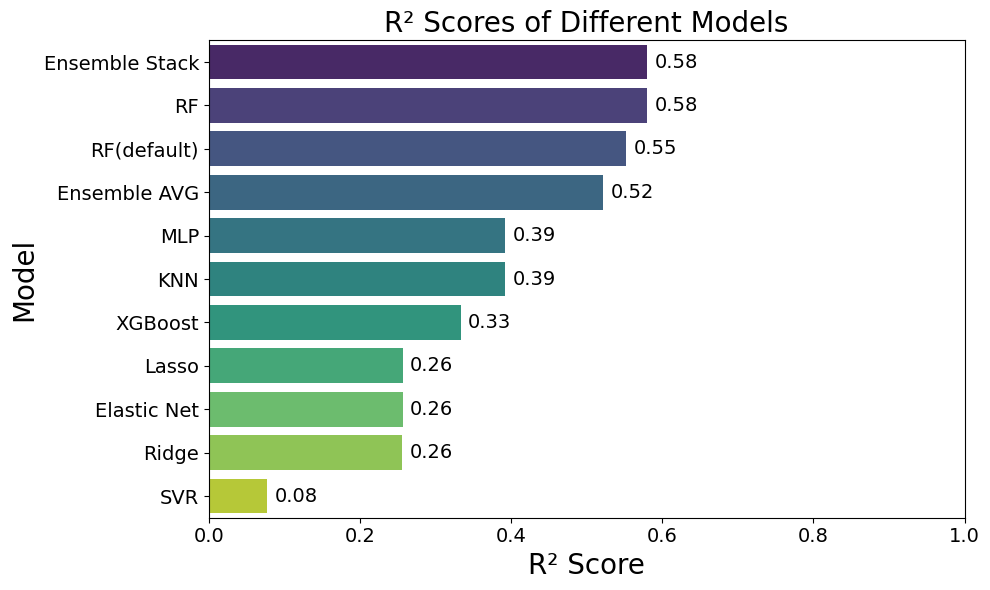

In [4]:
# Bar chart of R² scores
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='R² Score',
    y='Model',
    data=results,
    hue='Model',
    palette='viridis',
    legend=False
)

ax.grid(False)

# Add R² value labels on each bar
for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        y_pos = bar.get_y() + bar.get_height() / 2
        ax.text(width + 0.01, y_pos, f"{width:.2f}", va='center', ha='left', fontsize=14)

ax.tick_params(axis='both', labelsize=14)
plt.title('R² Scores of Different Models', fontsize=20)
plt.xlabel('R² Score', fontsize=20)
plt.ylabel('Model', fontsize = 20)
plt.xlim(0,1)
plt.tight_layout()
plt.show()


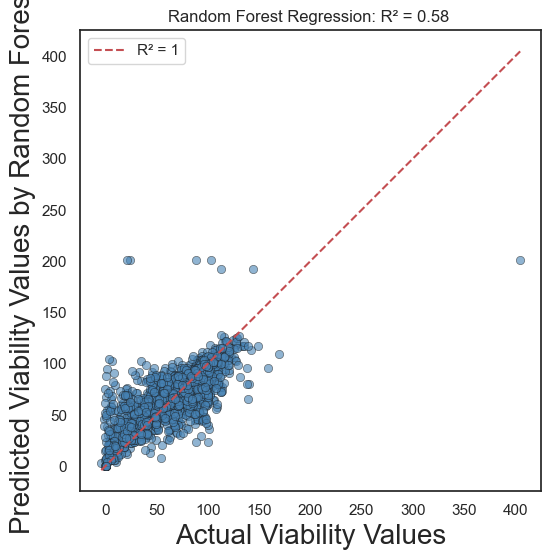

In [ ]:
# y_test vs y_pred_rf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create scatter plot
sns.set_style("white")
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, color="steelblue", alpha=0.6, edgecolor='k')

# Plot y = x line for reference
max_val = max(max(y_test), max(y_pred_rf))
min_val = min(min(y_test), min(y_pred_rf))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='R² = 1')

# Labels and title
plt.xlabel("Actual Viability Values")
plt.ylabel("Predicted Viability Values by Random Forest")
plt.title(f"Random Forest Regression: R² = {r2_rf:.2f} ")
plt.legend()
# Set 1:1 aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


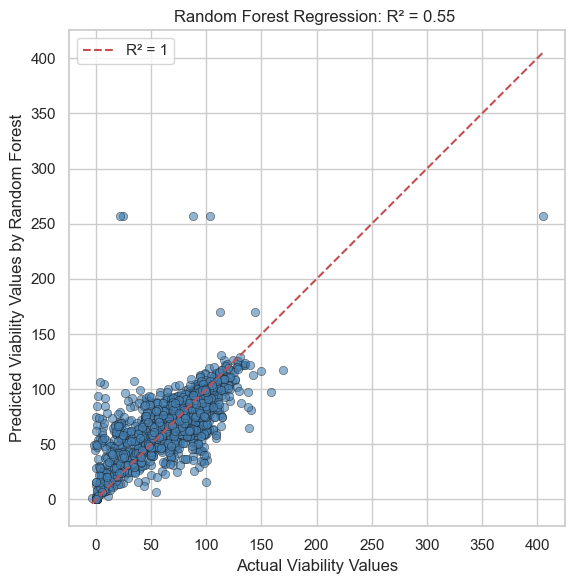

In [ ]:
# The new RF seems to have less wrong predictions and removed the incorrect ones at 250

# Plot the old RF (without tuning) vs y_test
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create scatter plot
sns.set_style("white")
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf_old, color="steelblue", alpha=0.6, edgecolor='k')

# Plot y = x line for reference
max_val = max(max(y_test), max(y_pred_rf_old))
min_val = min(min(y_test), min(y_pred_rf_old))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='R² = 1')

# Labels and title
plt.xlabel("Actual Viability Values")
plt.ylabel("Predicted Viability Values by Random Forest")
plt.title(f"Random Forest Regression: R² = {r2_rf_old:.2f} ")
plt.legend()
# Set 1:1 aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


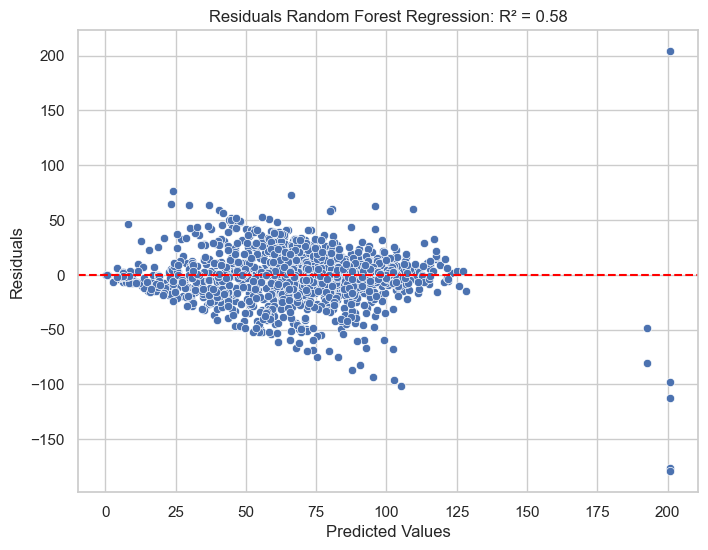

In [97]:
# Residuals plot for Random Forest (new model)

residuals = y_test - y_pred_rf
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residuals Random Forest Regression: R² = {r2_rf:.2f}')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


Top 10 Feature Importances:
Dose_microg_mL           0.157596
core_size_nm             0.145883
Duration_h               0.078924
NP_type_Ag               0.033921
NP_type_ZnO              0.028773
cell_Organ_BoneMarrow    0.022332
NP_type_MWCNT            0.020844
NP_type_CdTe             0.019134
NP_type_SLN              0.018888
NP_type_CuO              0.014804
dtype: float64


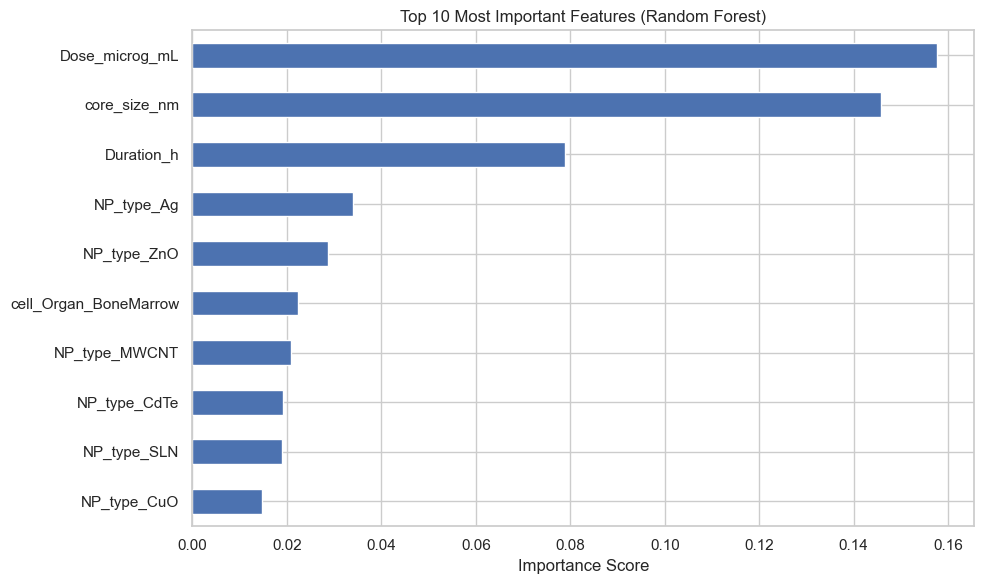

In [98]:
# Random Forest feature importance
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled_df.columns)
top_importances = importances.sort_values(ascending=False).head(10)

print("Top 10 Feature Importances:")
print(top_importances)

plt.figure(figsize=(10, 6))
top_importances.plot(kind='barh')
plt.gca().invert_yaxis()  # Most important on top
plt.title("Top 10 Most Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


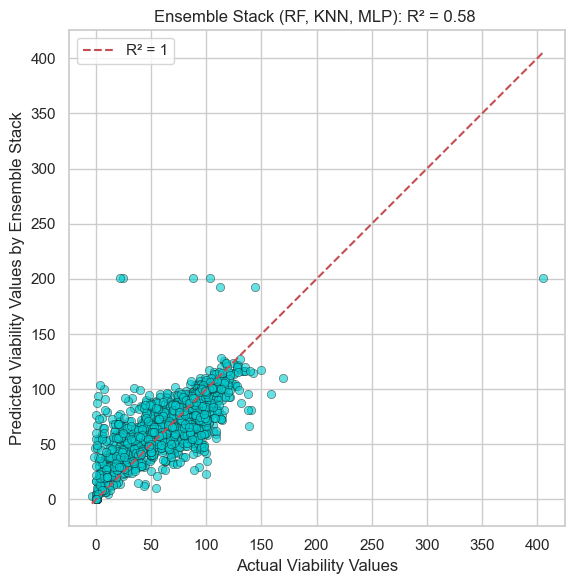

In [99]:
# Plot the stack predictions vs y_test
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=stack_preds, color="darkturquoise", alpha=0.6, edgecolor='k')

# Plot y = x line for reference
max_val = max(max(y_test), max(stack_preds))
min_val = min(min(y_test), min(stack_preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='R² = 1')

# Labels and title
plt.xlabel("Actual Viability Values")
plt.ylabel("Predicted Viability Values by Ensemble Stack")
plt.title(f"Ensemble Stack (RF, KNN, MLP): R² = {r2_stack:.2f} ")
plt.legend()
# Set 1:1 aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


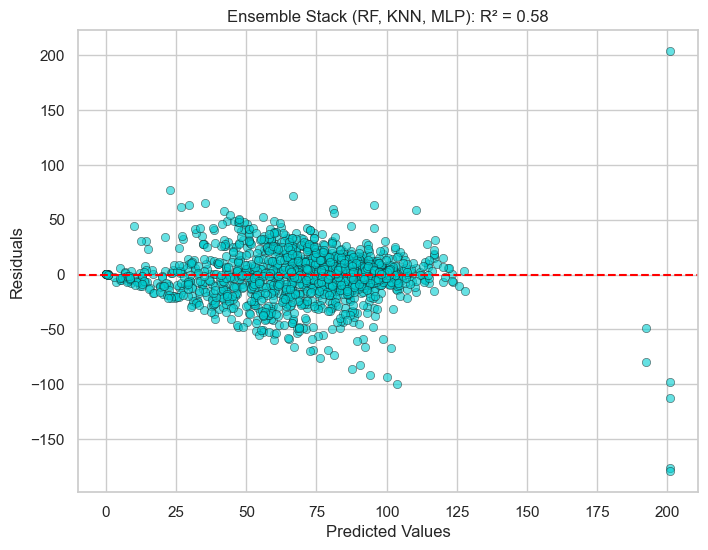

In [100]:
# Residuals plot for Stack

residuals = y_test - stack_preds
plt.figure(figsize=(8, 6))
sns.scatterplot(x=stack_preds, y=residuals, color="darkturquoise", alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Ensemble Stack (RF, KNN, MLP): R² = {r2_stack:.2f}')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()
